In [1]:
import tensorflow as tf
import sys
sys.path.insert(0, '/home/ading/dev/empirical-mt')
sys.path.insert(0, '/home/ading/dev/pyflow/')

from skimage import io, img_as_ubyte, color, draw
import numpy as np


import matplotlib.pyplot as plt

from visual_tracking.utils import est_contrast_flow_input_pip

import pandas as pd

import numpy as np
import pyflow

import cv2

In [45]:
ne = alov300_input_pipeline2.AvgOpticFlowInputFunc(dataset_index_filepath='../data/alov300++/alov300_train.csv', input_path='../', batch_size=1000, num_epochs=1, shuffle_buffer_size=10000)()

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.string, tf.string, tf.int32, tf.int32)>
<ParallelMapDataset shapes: (<unknown>, <unknown>, <unknown>), types: (tf.float32, tf.float32, tf.float32)>
intput pipline initilized, input_shpae=(TensorShape(None), TensorShape(None), TensorShape(None)), input_dtype=(tf.float32, tf.float32, tf.float32)


In [46]:
x_avg = np.array([])
y_avg = np.array([])
offsets = np.array([]).reshape((0, 2))

with tf.Session() as sess:
    for _ in range(0, 1): 
        r = sess.run(ne)
        x_avg = np.concatenate([x_avg, r[0]])
        y_avg = np.concatenate([y_avg, r[1]])
        offsets = np.concatenate([offsets, r[2]])
        

In [4]:
x_avg.shape

(10000,)

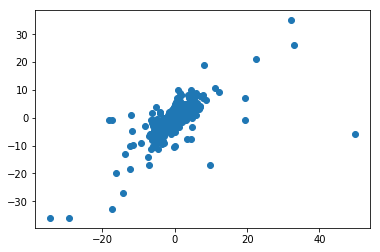

In [4]:
plt.scatter(x_avg, offsets[:, 1])

plt.show()

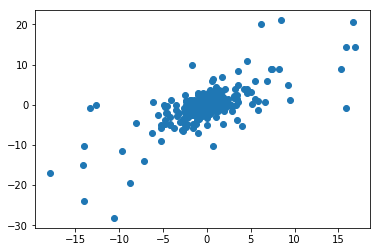

In [7]:
plt.scatter(y_avg, offsets[:, 0])

plt.show()

In [6]:
pd.Series(offsets[:, 1]).describe()

count    1000.000000
mean       -0.119753
std         3.992510
min       -36.000000
25%        -0.428237
50%         0.000000
75%         0.462967
max        34.993958
dtype: float64

In [10]:
df = pd.DataFrame.from_dict({'f_x': x_avg, 'f_u': y_avg, 'o_x': offsets[:, 1], 'o_y': offsets[:, 0]})

In [26]:
df['o_x'].describe()

count    10000.000000
mean         0.002200
std          4.317807
min        -56.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max         52.000000
Name: o_x, dtype: float64

In [27]:
df['o_y'].describe()

count    10000.000000
mean         0.028600
std          3.462713
min        -72.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         38.000000
Name: o_y, dtype: float64

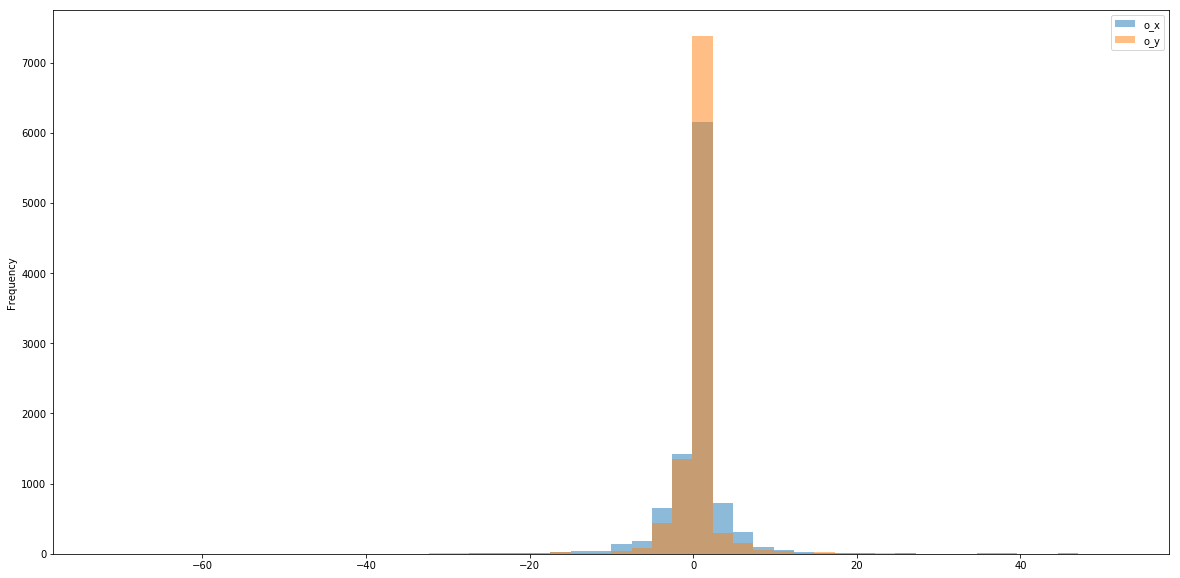

In [25]:
plt.figure(figsize=(20, 10))

df[['o_x', 'o_y']].plot.hist(bins=50, alpha=0.5, figsize=(20, 10))


In [8]:
np.array([1,2,3]) + 1

array([2, 3, 4])

In [4]:
ne = est_contrast_flow_input_pip.EstimatorOpticFlowInputFunc(dataset_index_filepath='../data/alov300++/alov300_train.csv', input_path='../', fixed_input_dim=76, batch_size=1000, num_epochs=1, shuffle_buffer_size=10000)()

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.string, tf.string, tf.int32, tf.int32)>
<ParallelMapDataset shapes: (<unknown>, <unknown>, <unknown>, <unknown>, <unknown>), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>
intput pipline initilized, input_shpae=(TensorShape(None), TensorShape(None), TensorShape(None), TensorShape(None), TensorShape(None)), input_dtype=(tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)


In [5]:
x_in_avg = []
y_in_avg = []
x_out_avg = []
y_out_avg = []
offsets = []
speed = []

with tf.Session() as sess:
    while True: 
        try:
            r = sess.run(ne)
        except tf.errors.OutOfRangeError:
            break
        for f1, f2, f, b1, b2 in zip(*r):
            b1_center = (b1[0:2] + b1[2:4]) / 2.
            b2_center = (b2[0:2] + b2[2:4]) / 2.
            offset = b2_center - b1_center
            offsets.append(offset)
            
            flow_x = f[:, :, 0].astype(np.float32)
            flow_y = f[:, :, 1].astype(np.float32)

            # compute average of optic flow inside bounding box
            box_mask = np.zeros_like(flow_x, dtype=np.float32)
            y_min, x_min, y_max, x_max = np.round(b1 * 76).astype(np.int32)
            rr, cc = draw.rectangle((y_min, x_min), (y_max, x_max), shape=box_mask.shape)
            box_mask[rr, cc] = 1.

            avg_flow_in_x = np.sum(np.multiply(flow_x, box_mask)) / np.sum(box_mask)
            avg_flow_in_y = np.sum(np.multiply(flow_y, box_mask)) / np.sum(box_mask)
            
            avg_flow_out_x = np.sum(np.multiply(flow_x, 1 - box_mask)) / np.sum(1 - box_mask)
            avg_flow_out_y = np.sum(np.multiply(flow_y, 1 - box_mask)) / np.sum(1 - box_mask)
        
            
            x_in_avg.append(avg_flow_in_x)
            y_in_avg.append(avg_flow_in_y)
            
            # print(x_in_avg, b1, b2, f)
            
            x_out_avg.append(avg_flow_out_x)
            y_out_avg.append(avg_flow_out_y)
            
            speed.append(np.linalg.norm(f, ord=2, axis=2))

/home/ading/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/ading/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ading/.local/lib/python2.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


InvalidArgumentError: exceptions.ValueError: need more than 2 values to unpack
	 [[Node: PyFunc = PyFunc[Tin=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], Tout=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], token="pyfunc_12"](arg0, arg1, arg2, arg3)]]
	 [[Node: IteratorGetNext_2 = IteratorGetNext[output_shapes=[<unknown>, <unknown>, <unknown>, <unknown>, <unknown>], output_types=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_2)]]

In [15]:
df = pd.DataFrame.from_dict({'avg_in_x': x_in_avg, 'avg_in_y': y_in_avg, 'avg_out_x':x_out_avg, 'avg_out_y':y_out_avg,
                            'offsets_x': np.stack(offsets, axis=0)[:, 1], 'offsets_y': np.stack(offsets, axis=0)[:, 0]})

In [16]:
df.head()

,avg_in_x,avg_in_y,avg_out_x,avg_out_y,offsets_x,offsets_y
0,0.221078,-0.026421,0.059091,0.003845,0.000718,-0.001452
1,-0.157350,0.036010,-0.344288,0.125670,0.000000,0.000000
2,0.012294,-0.004076,0.061169,-0.116413,0.000000,0.000000
3,0.018077,0.048433,-0.174070,0.069307,0.000000,0.000000
4,0.034295,-0.024701,0.040273,-0.030663,0.000000,0.000000


In [17]:
df.to_csv('temp_flow_vs_offsets.csv', index=False)

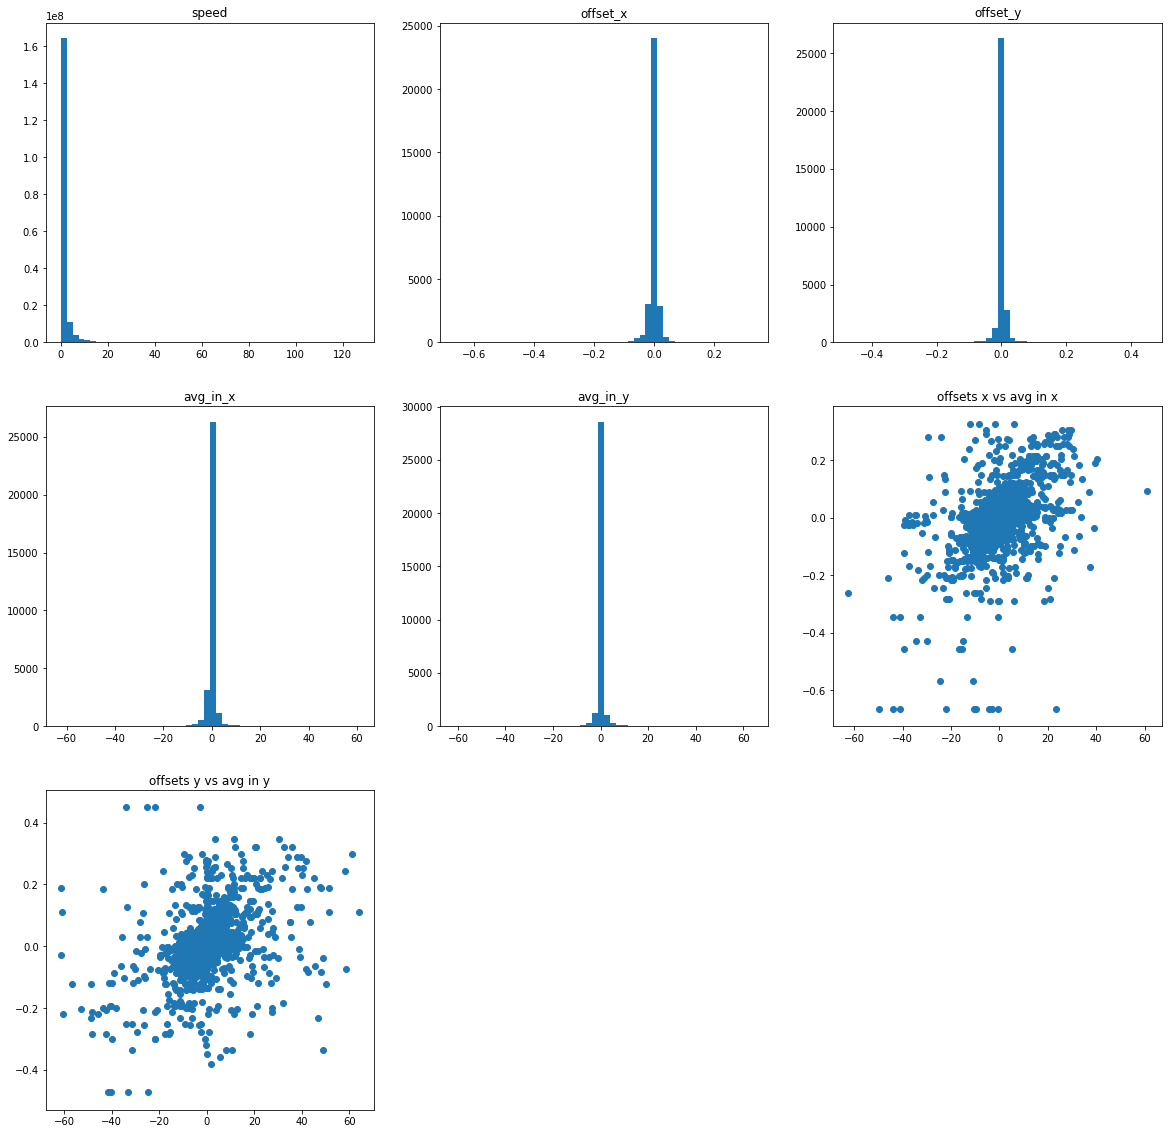

In [8]:
r = 3
c = 3

plt.figure(figsize=(20, 20))

plt.subplot(r, c, 1)
plt.hist(np.stack(speed, axis=0).flatten(), bins=50);
plt.title('speed')

plt.subplot(r, c, 2)
plt.hist(np.stack(offsets, axis=0)[:, 1], bins=50);
plt.title('offset_x')

plt.subplot(r, c, 3)
plt.hist(np.stack(offsets, axis=0)[:, 0], bins=50);
plt.title('offset_y')

plt.subplot(r, c, 4)
plt.hist(np.array(x_in_avg), bins=50);
plt.title('avg_in_x')

plt.subplot(r, c, 5)
plt.hist(np.array(y_in_avg), bins=50);
plt.title('avg_in_y')

plt.subplot(r, c, 6)
plt.scatter(np.array(x_in_avg), np.stack(offsets, axis=0)[:, 1]);
plt.title('offsets x vs avg in x')

plt.subplot(r, c, 7)
plt.scatter(np.array(y_in_avg), np.stack(offsets, axis=0)[:, 0]);
plt.title('offsets y vs avg in y')

plt.show()


Text(0.5,1,u'speed')

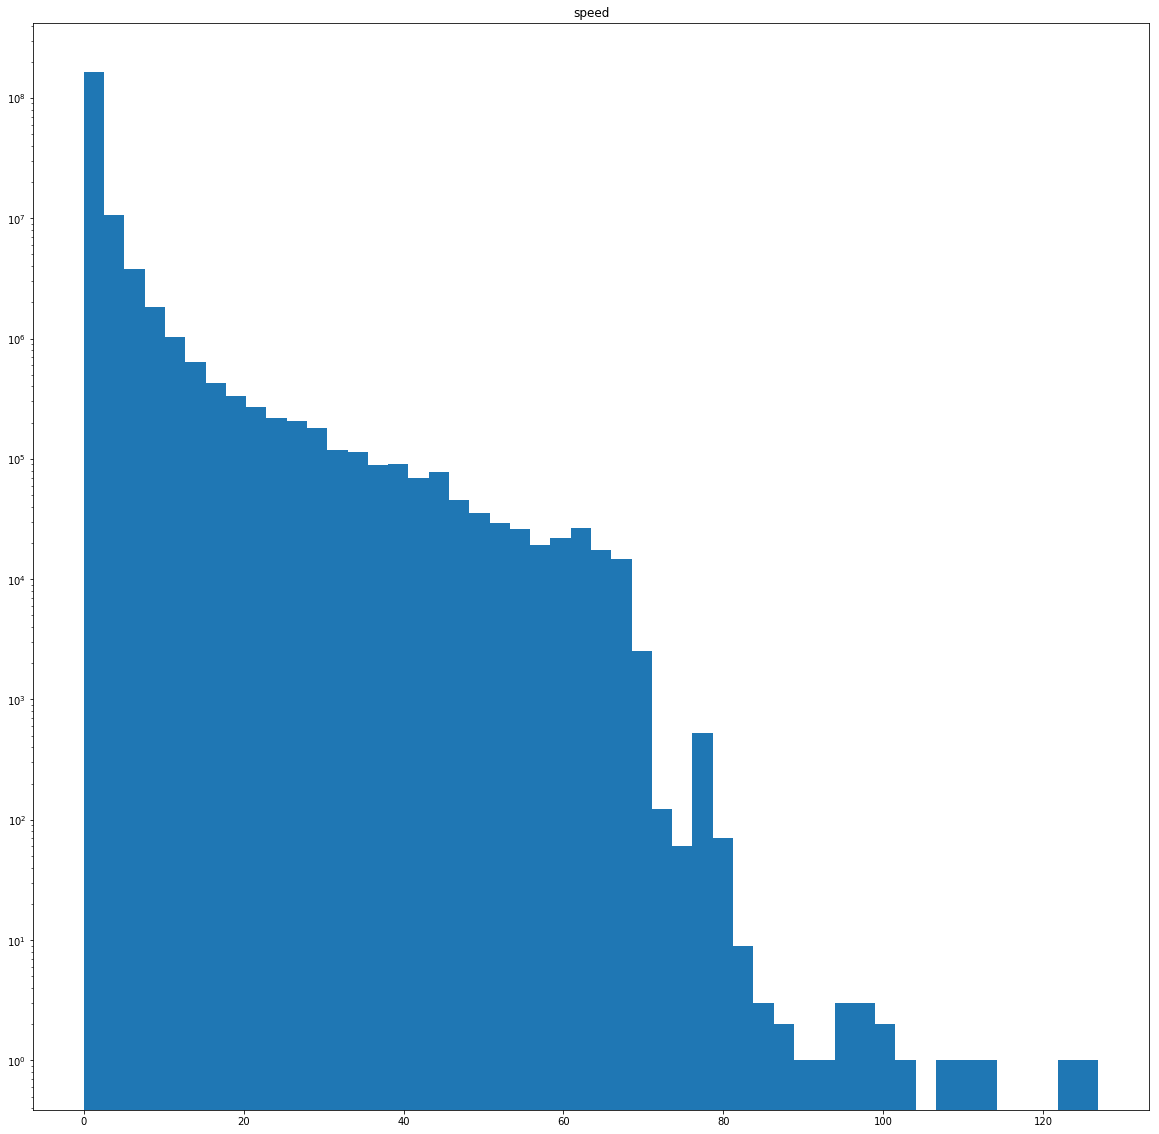

In [19]:
plt.figure(figsize=(20, 20))

plt.hist(np.stack(speed, axis=0).flatten(), bins=50, log=True);
plt.title('speed')

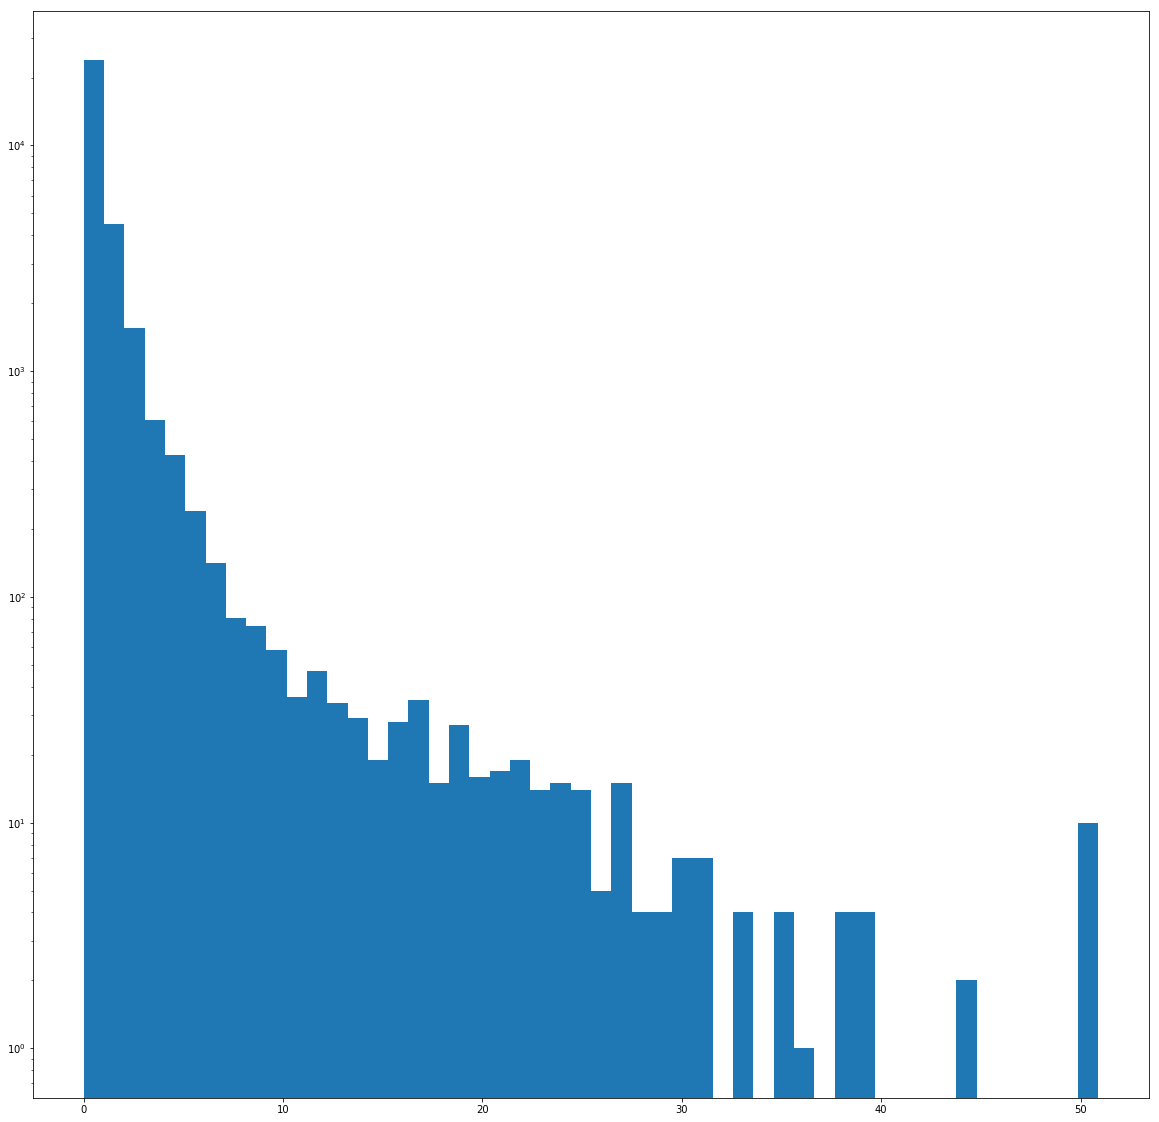

In [30]:
plt.figure(figsize=(20, 20))

plt.hist(np.linalg.norm(offsets, ord=2, axis=1) * 76, bins=50, log=True);

In [28]:
offsets * 76

[array([-0.00145197,  0.00071782], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([ 0.        ,  0.00289738], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([ 0.        ,  0.02247602], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([ 0.        ,  0.00573367], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([ 0.00225604,  0.00230634], dtype=float32),
 array([ 0.00718176,  0.00907302], dtype=float32),
 array([ 0.00219506,  0.00227141], dtype=float32),
 array([-0.00289285, -0.00169271], dtype=float32),
 array([-0.00310796,  0.00233495], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([ 0.        ,  0.00933981], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([ 0.00628221, -0.00747487], 

In [66]:
speed = []

with tf.Session() as sess:
    for _ in range(0, 1): 
        r = sess.run(ne)
        for f1, f2, f, b1, b2 in zip(*r):
            speed.append(np.linalg.norm(f2, ord=2, axis=2))

In [98]:
speed = []

for f1, f2, f, b1, b2 in zip(*r):
    speed.append(np.linalg.norm(f, ord=2, axis=2))

In [96]:
len(r)

5

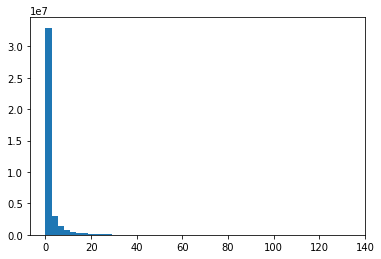

In [91]:
plt.hist(np.linalg.norm(r[2], ord=2, axis=3).flatten(), bins=50);

In [72]:
pd.Series(np.stack(speed, axis=0).flatten()).describe()

count    4.000000e+07
mean     6.739981e-01
std      3.896940e-01
min      0.000000e+00
25%      3.765246e-01
50%      7.236103e-01
75%      9.375513e-01
max      1.732051e+00
dtype: float64

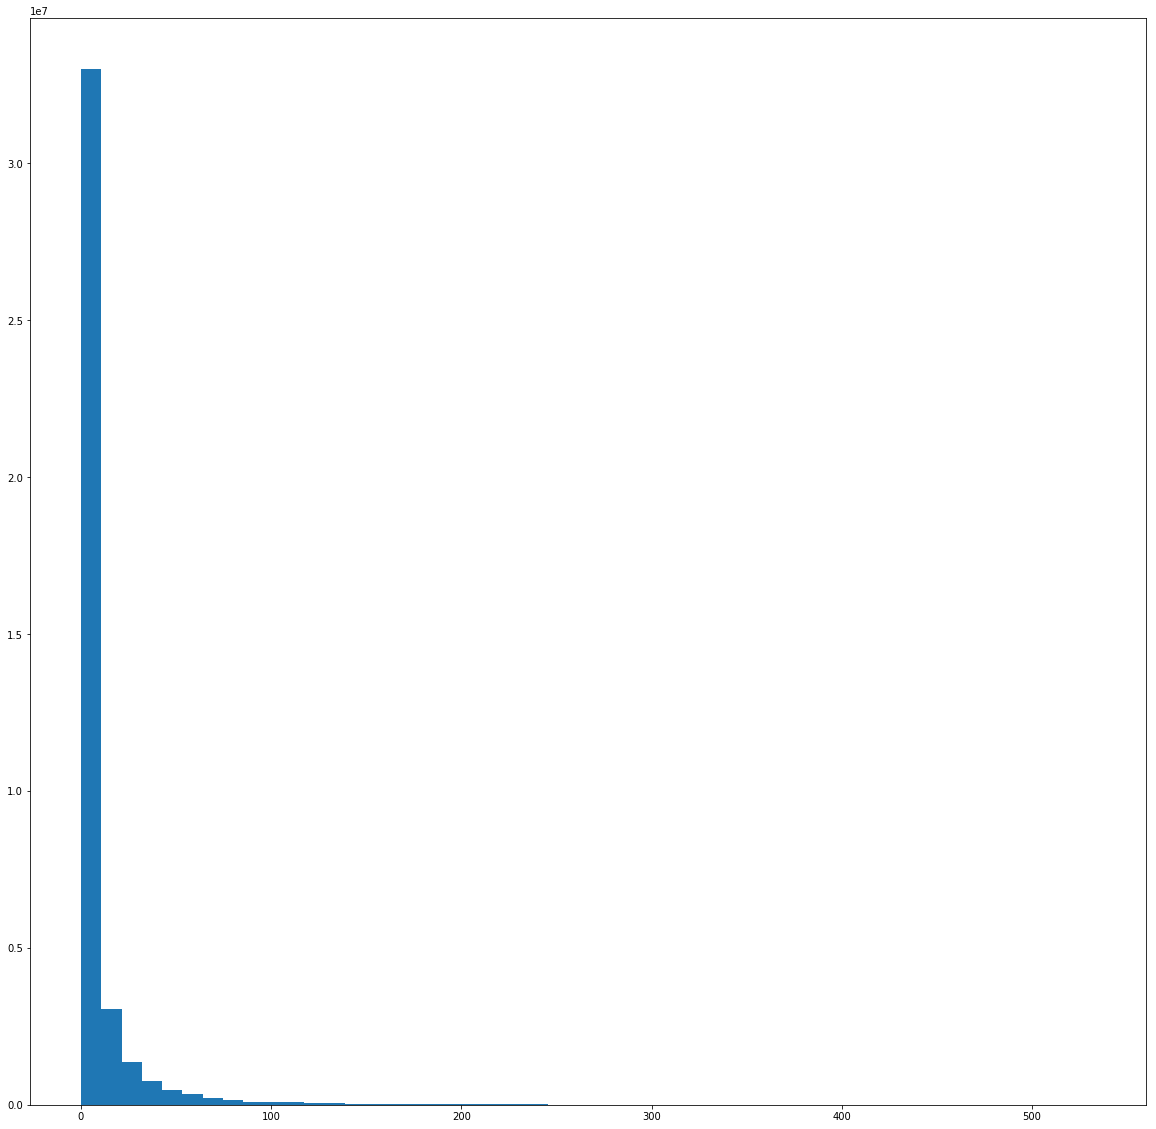

In [106]:
plt.figure(figsize=(20, 20))

plt.hist(np.stack(speed, axis=0).flatten() * 4, bins=50);

In [24]:
x_avg

[0.84086239, -9.6385736, -1.9614261, 0.21549515, -0.0043218788]

In [11]:
offsets = np.stack(offsets, axis=0)

In [14]:
pd.Series(offsets[:, 1] * 200).describe()

count    1000.000000
mean        0.222594
std         4.496990
min       -27.914434
25%        -0.203049
50%         0.000000
75%         0.392431
max        53.521324
dtype: float64

In [74]:
x_avg

array([  3.52126867e-01,  -1.06461316e-01,  -4.42631054e+00,
        -2.74992734e-01,   3.75692725e-01,   1.75429821e-01,
        -1.29639554e+00,  -7.37632418e+00,  -2.16277075e+00,
        -1.46961346e+01,   1.35013616e+00,   1.65430629e+00,
         8.39328647e-01,   1.11842100e-02,  -2.85073102e-01,
        -2.55604357e-01,   4.99993473e-01,  -2.38663554e+00,
        -3.52131993e-01,   2.66651604e-02,   6.64214087e+00,
         8.65490615e-01,  -9.25906822e-02,   1.97409853e-01,
        -6.97715402e-01,   1.06371358e-01,  -9.90404546e-01,
        -8.64267498e-02,   4.08262682e+00,  -9.41979349e-01,
        -1.21733654e+00,   1.41464221e+00,  -1.34132481e+00,
         1.03697777e+00,   6.65992871e-02,  -1.34533234e+01,
        -2.92405796e+00,   5.68155348e-01,   1.68157309e-01,
        -4.97555658e-02,   8.98473114e-02,   3.10479581e-01,
         5.77735901e-01,  -8.46170545e-01,   6.89733505e-01,
        -6.71382248e-01,   6.39295530e+00,   4.01044178e+00,
         3.04833174e-01,

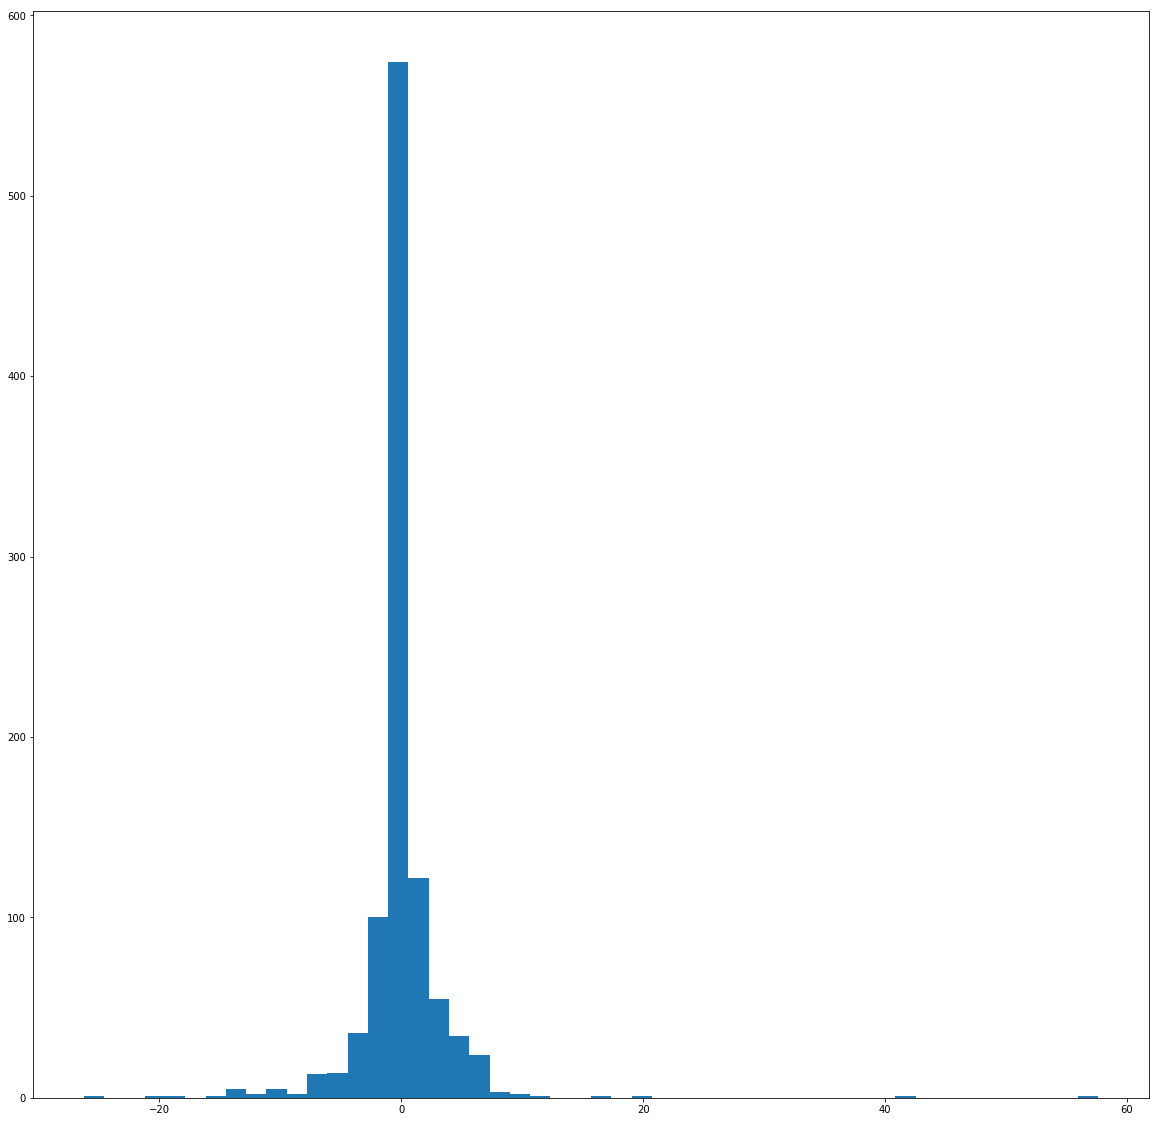

In [73]:
plt.figure(figsize=(20, 20))

plt.hist(x_avg, bins=50);

plt.show()

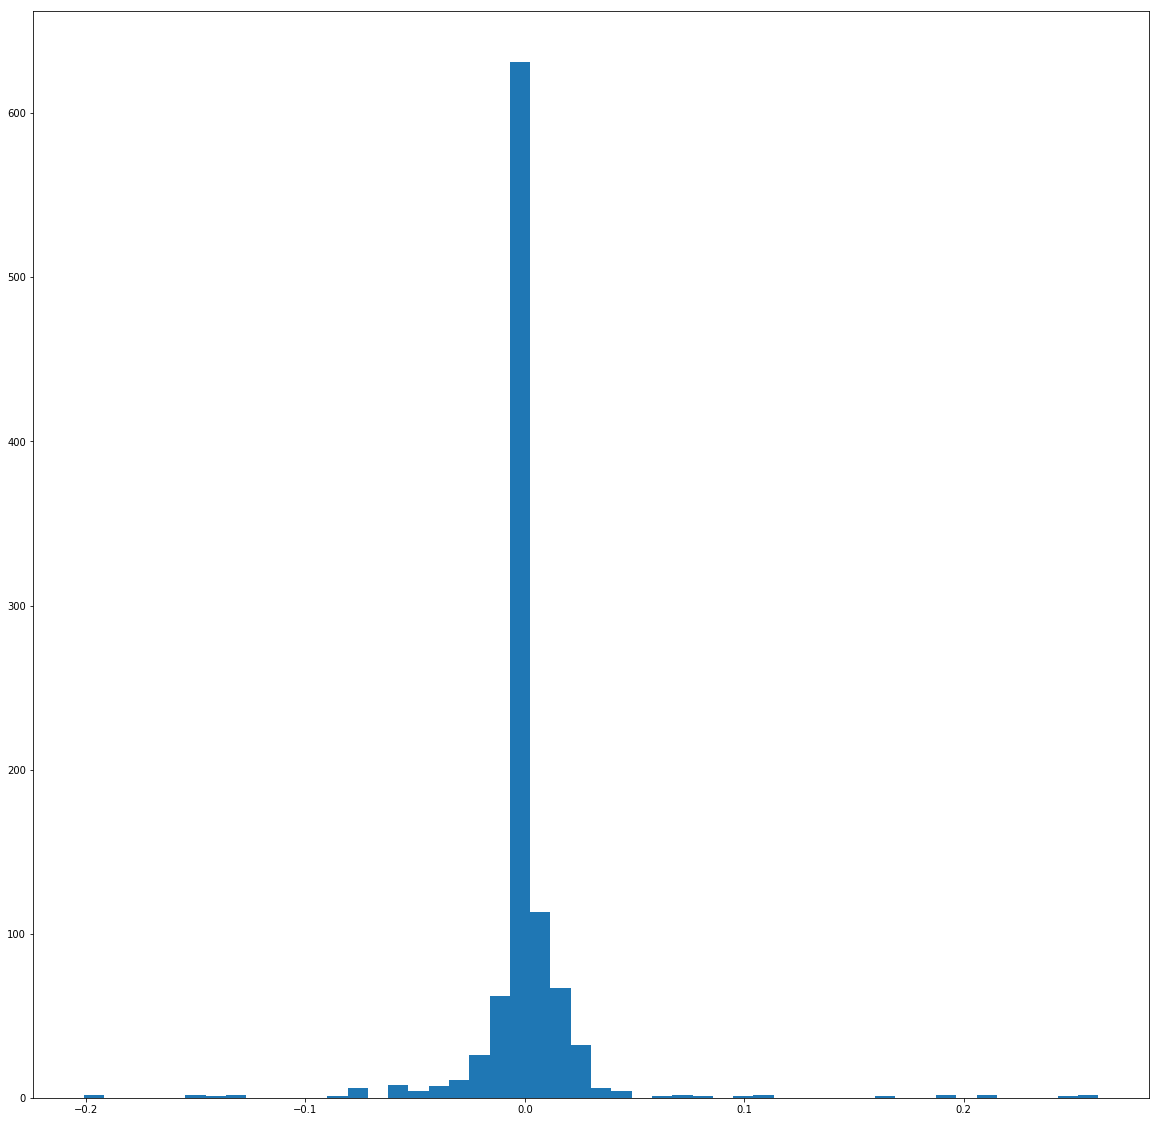

In [39]:
plt.figure(figsize=(20, 20))

plt.hist(np.stack(offsets, axis=0)[:, 1], bins=50);

plt.show()

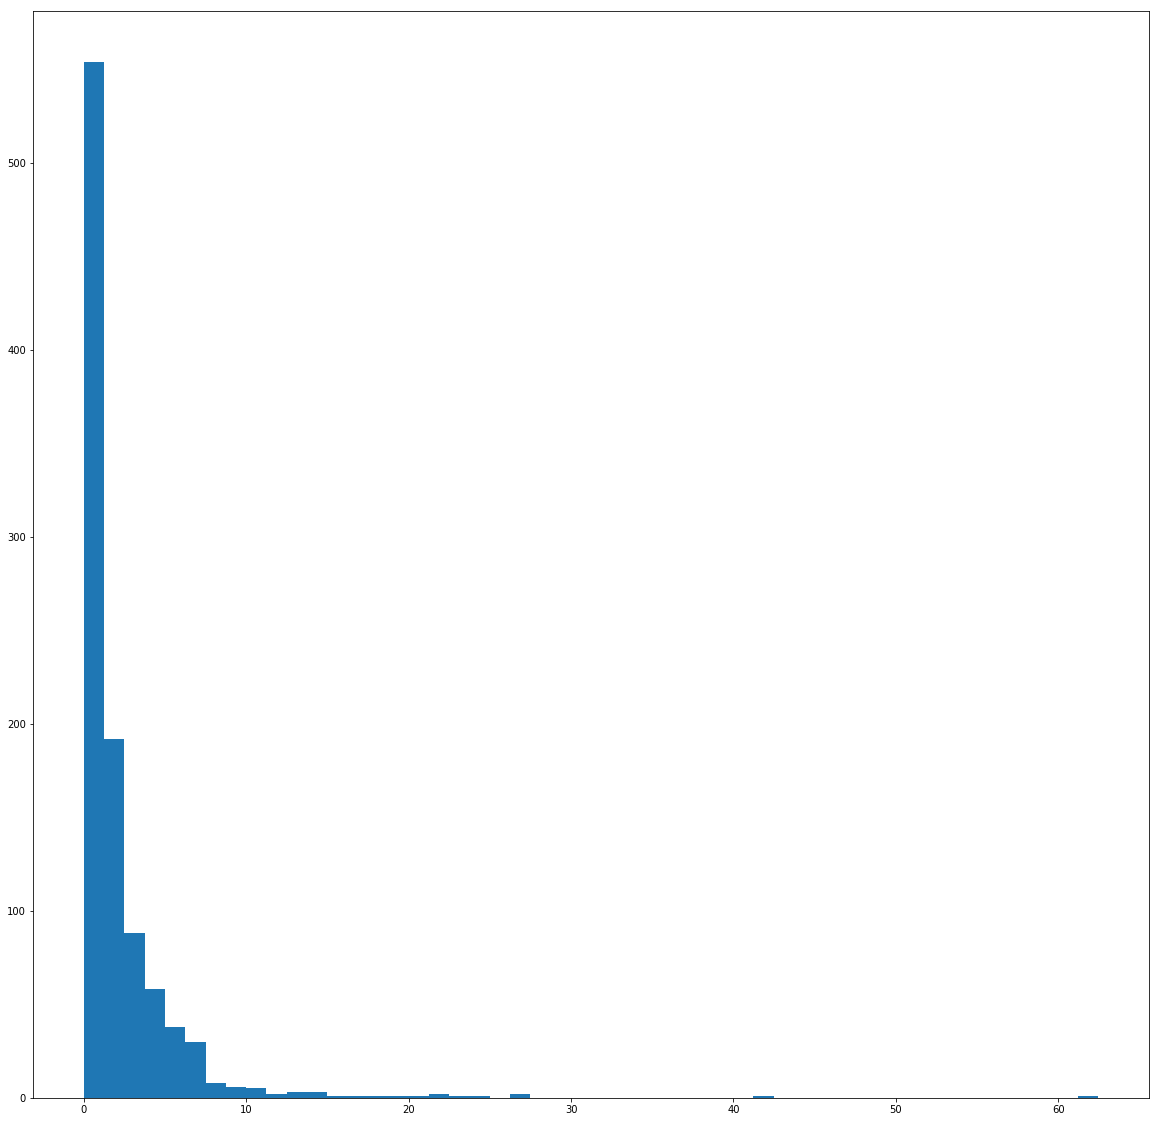

In [75]:
plt.figure(figsize=(20, 20))

plt.hist(np.sqrt(np.square(x_avg) + np.square(y_avg)), bins=50);

plt.show()

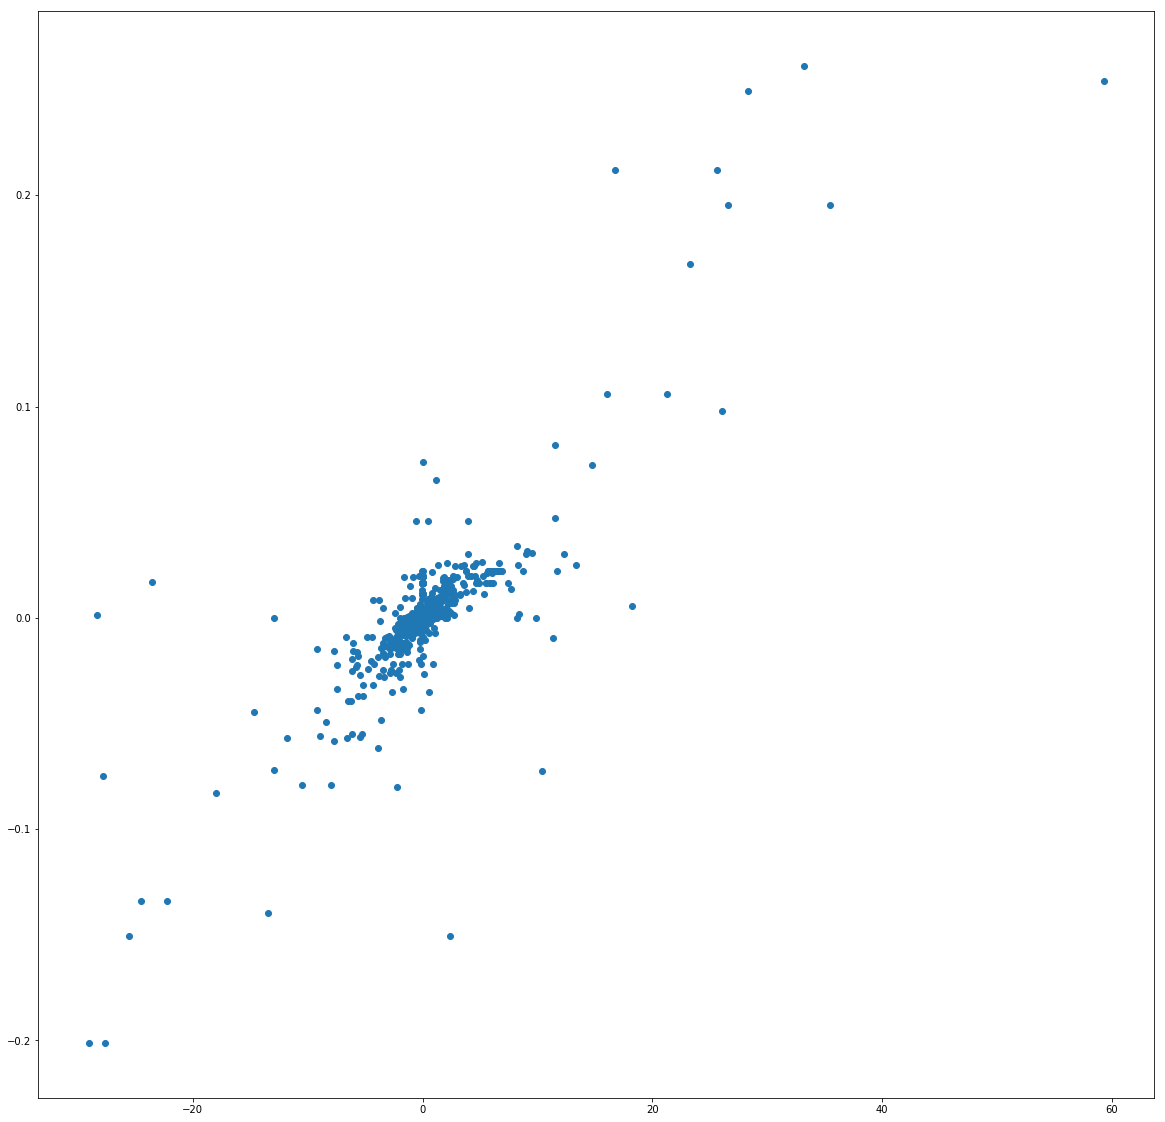

In [44]:
plt.figure(figsize=(20, 20))

plt.scatter(x_avg, np.stack(offsets, axis=0)[:, 1]);

plt.show()

In [78]:
np.linalg.norm([[3 ,-3], [1 ,- 1]], ord=2, axis=1)

array([ 4.24264069,  1.41421356])